In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [14]:
!nvidia-smi

Tue Aug  4 12:27:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.116.00   Driver Version: 418.116.00   CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   35C    P0    37W / 300W |      0MiB / 16130MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A   40C    P0    53W / 300W |     10MiB / 16130MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   2  T

In [15]:
import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
gpu_index = 1

print("Num GPUs Available: ", len(gpu_devices))
tf.config.set_visible_devices(gpu_devices[gpu_index], 'GPU')
tf.config.experimental.set_memory_growth(gpu_devices[gpu_index], True)

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

Num GPUs Available:  4


In [16]:
import sys
sys.path.append('..')

from bert.dataset import encode
from bert.model import create_model
from bert.go import TreeNorm
from bert.go import Ontology

In [17]:
ont = Ontology(threshold=1)

In [18]:
ont.total_nodes

32372

In [19]:
swissprot_dir = '/gpfs/alpine/bie108/proj-shared/swissprot/'
swissprot = pd.read_parquet(os.path.join(swissprot_dir, 'parsed_swissprot_uniref_clusters.parquet'))
go_terms = pd.read_parquet(os.path.join(swissprot_dir, 'swissprot_quickgo.parquet'))

swissprot_annotated = swissprot[swissprot.accession.isin(go_terms['GENE PRODUCT ID'].unique())]
swissprot_annotated = swissprot_annotated[swissprot_annotated.length < 10000]

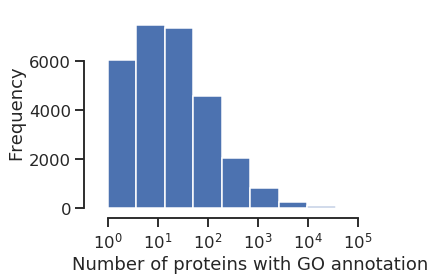

In [20]:
counts = go_terms['GO TERM'].value_counts()
np.log10(counts).plot.hist()
plt.xticks(ticks=np.arange(0, 6), labels=[f'$10^{i}$' for i in np.arange(0, 6)])
plt.xlabel('Number of proteins with GO annotation')
sns.despine(trim=True, offset=10)
plt.tight_layout()

In [21]:
dimension = 768
model = create_model(model_dimension=dimension,
                     transformer_dimension=dimension * 4,
                     num_attention_heads=dimension // 64,
                     num_transformer_layers=12,
                     vocab_size=24,
                     dropout_rate=0.0,
                     max_relative_position=64,
                     attention_type='relative')

## Append the GO annotations
final_embedding = model.layers[-2].input
raw_residue_predictions = tf.keras.layers.Dense(ont.total_nodes)(final_embedding)

protein_predictions = tf.keras.layers.GlobalMaxPooling1D()(raw_residue_predictions)

segments, ids = zip(*ont.iter_ancestor_array())
treenorm = TreeNorm(segments, ids)
normed = treenorm(protein_predictions)

go_model_sigmoid = tf.keras.Model(model.inputs, tf.nn.sigmoid(normed))

In [22]:
checkpoint = tf.train.latest_checkpoint('/ccs/home/pstjohn/member_work/uniparc_checkpoints/go_finetuning_new_split_1024_ont1.258061')
go_model_sigmoid.load_weights(checkpoint).expect_partial()

In [23]:
ont.get_head_node_indices()

[6, 3019, 4569]

In [24]:
ont.G.nodes[ont.term_index[6]]['name']

'biological_process'

In [27]:
def parse_example(example):
    parsed = tf.io.parse_single_example(example, features={
        'sequence': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'annotation': tf.io.FixedLenFeature([], tf.string, default_value=''),
    })
   
    sequence = encode(parsed['sequence'], 1024)
    annotation = tf.io.parse_tensor(parsed['annotation'], out_type=tf.int64)
    
    return sequence, annotation

valid_dataset = tf.data.TFRecordDataset(
    os.path.join(swissprot_dir, 'tfrecords_1', 'go_valid.tfrecord.gz'),
    compression_type='GZIP', num_parallel_reads=tf.data.experimental.AUTOTUNE)\
    .map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
    .padded_batch(batch_size=16,
                  padded_shapes=(([1024], [ont.total_nodes])))\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
y_true = []
y_pred = []

for batch in tqdm(valid_dataset):
    y_true += [batch[1].numpy()]
    y_pred += [go_model_sigmoid.predict(batch)]

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

np.savez_compressed('valid.258061.npz', y_true=y_true, y_pred=y_pred)

751it [07:32,  1.66it/s]


In [3]:
# saved = np.load('valid.258061.npz')
# y_true = saved['y_true']
# y_pred = saved['y_pred']

In [37]:
precision, recall, thresholds = precision_recall_curve(y_true.flatten(), y_pred.flatten())

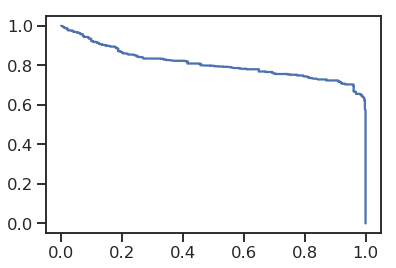

In [38]:
plt.plot(precision, recall)

In [32]:
go_model_sigmoid.predict(valid_dataset)

array([[4.046e-04, 4.046e-04, 7.949e-04, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.556e-05, 1.556e-05, 1.699e-05, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.846e-04, 3.846e-04, 2.958e-03, ..., 0.000e+00, 0.000e+00,
        0.000e+00]], dtype=float16)

In [ ]:
def predict(protein_seq, max_len=2048):
    return tf.nn.sigmoid(go_model(tf.expand_dims(encode(protein_seq, max_len), 0)))

In [ ]:
optimizer = tf.keras.optimizers.Adam(1E-4)

# metrics = [
#      LogitSplitFmax(ont, 0),
#      LogitSplitFmax(ont, 1),
#      LogitSplitFmax(ont, 2),    
# ]

# go_model.compile(
#    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#    metrics=metrics,
#    optimizer=optimizer)

In [ ]:
BP = ont.G.subgraph(ont.get_descendants('GO:0008150'))
MF = ont.G.subgraph(ont.get_descendants('GO:0003674'))
CC = ont.G.subgraph(ont.get_descendants('GO:0005575'))

In [ ]:
import networkx as nx

In [ ]:
prediction = predict(swissprot_annotated.iloc[3].sequence)

BP_sub = BP.subgraph(ont.array_to_termlist(prediction > 0.5))
MF_sub = MF.subgraph(ont.array_to_termlist(prediction > 0.5))
CC_sub = CC.subgraph(ont.array_to_termlist(prediction > 0.5))

In [ ]:
BP_sub.number_of_nodes(), MF_sub.number_of_nodes(), CC_sub.number_of_nodes()

In [ ]:
nx.algorithms.minimum_spanning_arborescence

In [ ]:
BP_sub.nodes['GO:1901564'].items()

In [ ]:
data = {}
data['BP'] = nx.tree_data(BP_sub.edge_subgraph(nx.algorithms.minimum_spanning_arborescence(BP_sub).edges()), 'GO:0008150')
data['MF'] = nx.tree_data(MF_sub.edge_subgraph(nx.algorithms.minimum_spanning_arborescence(MF_sub).edges()), 'GO:0003674')
data['CC'] = nx.tree_data(CC_sub.edge_subgraph(nx.algorithms.minimum_spanning_arborescence(CC_sub).edges()), 'GO:0005575')